## Students details

Student1
* Name: Uri Goodman
* ID: 315554907
* Username: urigoodman


### General tip

While debugging you might want to use:
```python
import importlib
importlib.reload(model)
```

to reload the model module without repeating unnecessary cells.

### Import relevant packages - you might need to pip install some 

In [ ]:
import torch
import data_loader
from traineval import train, evaluate
import model as model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"deviced used is {device}")

deviced used is cuda


In [ ]:
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
seed = 42

## Loading the Data

The following line of code invokes data_loader and will automatically download and extract the dataset if needed.
It instantiates the following variables;
* tokens_vocab - the sentence words vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with train,dev, and test WSDDataset instances.

Use the optional sentence_count kwarg to limit the number of sentences loaded.

In [ ]:
train_dataset, tokens_vocab, y_vocab = data_loader.load_train_dataset()
train_dataset

In [ ]:
dev_dataset = data_loader.load_dev_dataset(tokens_vocab, y_vocab)
dev_dataset

## Part 1: Query-Based Attention

Implement the relevant parts in model.py module. You might to check out this blog post about [gather method](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)

Load the model.

In [ ]:
dropout = 0.25
D = 300
lr = 8e-5
batch_size=100
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.502; epoch [4] loss: 2.738: 100%|██████████| 2042/2042 [00:41<00:00, 49.08it/s]


Train the model - you shoud see the loss decreasing and validation acc increasing from epoch to epoch.

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.514, "The last validation accuracy should be at least 0.514. Please check your implementation before you continue"

Validation accuracy: 0.515, Training accuracy:0.596


Plot the loss and training/validation accuracy. You should be getting ~54% validation accuracy after 10 epochs.

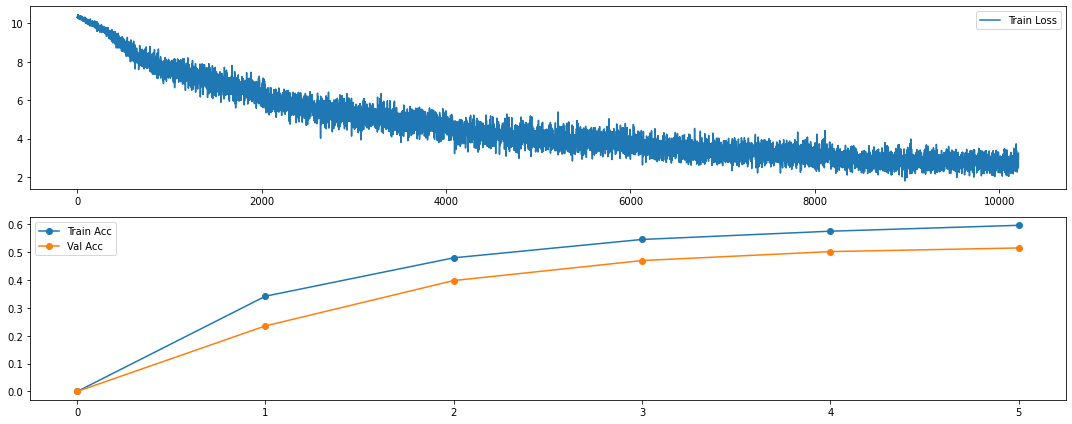

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

Use the attention vizualization to get a feel of what the model is attending to.

The query token is highlighted in green, and the model's attention with a pink-blue gradient.
In addition, the loss is given a red gradient.

In [ ]:
from traineval import higlight_samples

higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,1,is,be.v.01,be.v.01,7.141e-01,0.336773,It,is,natural,that,he,should,turn,for,his,major,support,to,a,select,and,dedicated,few,from,the,organization,which,actually,owns,the,university,and,whose,goals,are,",",in,their,opinion,",",identified,with,its,highest,good,and,(,to,use,that,<UNK>,phrase,),',the,attainment,of,excellence,'',',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40,hearing,hearing_examiner.n.01,hearing_examiner.n.01,5.403e-01,0.615580,He,says,that,he,was,not,permitted,to,rebut,before,the,hearing,officer,statements,attributed,to,him,by,the,local,board,",",and,",",further,",",that,he,was,denied,at,trial,the,right,to,have,the,Department,of,Justice,hearing,officer,'s,report,and,the,original,report,of,the,Federal,Bureau,of,Investigation,as,to,his,claim,-,all,in,violation,of,the,Fifth,Amendment,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,10,then,then.r.01,then.r.01,6.845e-01,0.379064,The,contents,of,the,manifold,for,liquid,phase,experiments,were,then,mixed,by,shaking,",",redistributed,to,the,reaction,tubes,",",frozen,down,",",and,each,tube,was,then,sealed,off,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,25,seems,look.v.02,look.v.02,7.359e-01,0.306698,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,11,Schwartz,person.n.01,person.n.01,9.988e-01,0.001224,Without,dissent,",",senators,passed,a,bill,by,Sen.,A.,R.,Schwartz,of,<UNK>,authorizing,establishment,in,the,future,of,a,school,for,the,mentally,retarded,in,the,Gulf,Coast,district,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


We notice that a large emphasis is placed on the period at the end of the sentence.
In addition, the "empty space" after the sentence has has ended has a non-zero weight meaning that it has some effect on our model even though it has no meaning.
We will remedy this in the next part!"

## Part 2: Padding

Implement the padding mask in the attention function in model.py.

Load the model and retrain.

In [ ]:
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.515; epoch [4] loss: 2.637: 100%|██████████| 2042/2042 [00:42<00:00, 48.16it/s]


In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.527, "The last validation accuracy should be at least 0.527. Please check your implementation before you continue"

Validation accuracy: 0.527, Training accuracy:0.617


By adding the simple masking mechanism we have already seen an accuracy improvement of 0.13, exciting!

**Plot** the loss and training/validation accuracy.

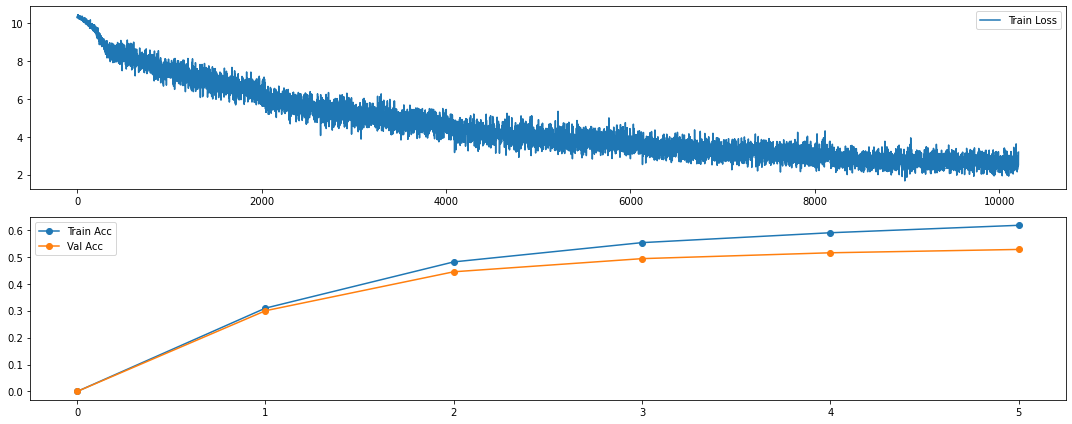

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [ ]:
higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,1,is,be.v.01,be.v.01,8.170e-01,0.202056,It,is,natural,that,he,should,turn,for,his,major,support,to,a,select,and,dedicated,few,from,the,organization,which,actually,owns,the,university,and,whose,goals,are,",",in,their,opinion,",",identified,with,its,highest,good,and,(,to,use,that,<UNK>,phrase,),',the,attainment,of,excellence,'',',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40,hearing,hearing_examiner.n.01,hearing_examiner.n.01,4.899e-01,0.713471,He,says,that,he,was,not,permitted,to,rebut,before,the,hearing,officer,statements,attributed,to,him,by,the,local,board,",",and,",",further,",",that,he,was,denied,at,trial,the,right,to,have,the,Department,of,Justice,hearing,officer,'s,report,and,the,original,report,of,the,Federal,Bureau,of,Investigation,as,to,his,claim,-,all,in,violation,of,the,Fifth,Amendment,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,10,then,then.r.01,then.r.01,6.986e-01,0.358615,The,contents,of,the,manifold,for,liquid,phase,experiments,were,then,mixed,by,shaking,",",redistributed,to,the,reaction,tubes,",",frozen,down,",",and,each,tube,was,then,sealed,off,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,25,seems,look.v.02,look.v.02,7.582e-01,0.276811,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,11,Schwartz,person.n.01,person.n.01,9.978e-01,0.002231,Without,dissent,",",senators,passed,a,bill,by,Sen.,A.,R.,Schwartz,of,<UNK>,authorizing,establishment,in,the,future,of,a,school,for,the,mentally,retarded,in,the,Gulf,Coast,district,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Examine additional examples, using the API and pandas as demonstrated below.

In [ ]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, dev_dataset, iter_lim=100)

Visualization of 5 incorrectly classified examples.

In [ ]:
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,7,men,work_force.n.01,man.n.01,1.165e-01,2.149590,It,included,the,top,O,',Banion,men,and,Chief,of,<UNK>,Michael,Hughes,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,3,get,arrive.v.01,get.v.01,9.639e-02,2.339382,How,did,we,get,here,'',?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,8,establish,establish.v.02,establish.v.01,4.006e-01,0.914816,His,purpose,",",however,",",was,not,to,establish,an,empire,",",but,to,assert,the,principle,of,divine,justice,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,41,thinking,think.v.02,think.v.03,9.037e-02,2.403895,Instead,of,her,old,confidence,in,the,simplest,",",purest,",",most,moving,musical,expression,",",Miss,Schwarzkopf,is,letting,herself,be,tempted,by,the,classic,sin,of,artistic,pride,-,that,subtle,vanity,that,sometimes,<UNK>,a,great,artist,into,thinking,that,he,or,she,can,somehow,better,the,music,by,bringing,to,it,something,extra,",",some,personal,dramatic,touch,imposed,from,the,outside,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,6,12,as,so_far.r.01,such_as.s.00,2.047e-02,3.888741,If,private,brand,competition,has,n't,been,felt,in,your,product,field,as,yet,",",have,you,thought,how,you,will,cope,with,it,if,and,when,it,does,appear,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Visualization of examples with the query word "left".

In [ ]:
idxs = np.where(eval_df['query_token'] == 'left')
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
333,333,17,left,left.a.01,leave.v.01,9.994e-02,2.303187,Start,with,the,class,standing,in,a,circle,",",with,weight,on,the,right,foot,and,the,left,extended,a,little,way,into,the,circle,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
734,734,1,left,leave.v.02,leave.v.01,4.765e-02,3.043920,Chandler,left,Carroll,at,the,bottom,of,the,hill,to,direct,any,reinforcements,he,could,find,to,the,fight,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1029,1029,24,left,left_ventricle.n.01,leave.v.01,1.599e-03,6.438492,It,is,also,possible,to,utilize,a,pressure,transducer,",",mounted,at,the,end,of,a,<UNK>,which,is,inserted,into,the,heart,'s,left,ventricle,",",to,indicate,the,blood,pressure,in,the,heart,itself,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2311,2311,29,left,leftover.s.01,leave.v.01,6.795e-02,2.689033,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2881,2881,2,left,leave.v.04,leave.v.01,2.113e-02,3.857225,He,had,left,her,inviolate,",",thinking,familiarity,would,gentle,her,in,time,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3109,3109,4,left,leave.v.01,leave.v.01,4.785e-01,0.737008,``,Just,<UNK>,he,left,<UNK>,his,<UNK>,we,<UNK>,hevin,<UNK>,on,the,<UNK>,",",Major,Roebuck,an,Ah,",",an,<UNK>,says,',May,Ah,<UNK>,one,too,',?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3390,3390,9,left,leave.v.01,leave.v.01,4.153e-01,0.878692,By,this,time,large,numbers,of,the,audience,had,left,the,hall,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3605,3605,5,left,leave.v.02,leave.v.01,5.076e-02,2.980654,My,men,",",they,all,left,me,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4477,4477,12,left,leave.v.02,leave.v.01,4.974e-02,3.001039,The,proteins,and,fats,are,burned,off,",",and,the,cholesterol,is,left,behind,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4705,4705,1,left,leave.v.01,leave.v.01,5.205e-01,0.653036,Beckworth,left,the,tent,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 3: Self-Attention

The method below converts the query-based instances in WSDDataset to sentence-level instances in WSDSentencesDataset for self-attention.

Notice how the number of samples now equals number of sentences.

In [ ]:
sa_train_dataset = data_loader.WSDSentencesDataset.from_word_dataset(train_dataset)
sa_train_dataset

Samples: 29740
Sentences: 29740 (N=270)
Vocab:
	Tokens:39272
	Senses:25378

In [ ]:
sa_dev_dataset = data_loader.WSDSentencesDataset.from_word_dataset(dev_dataset)
sa_dev_dataset

Samples: 3717
Sentences: 3717 (N=134)
Vocab:
	Tokens:39272
	Senses:25378

Implement self-attention in the model.

Load the model and retrain.

In [10]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.540; epoch [4] loss: 1.728: 100%|██████████| 1487/1487 [02:34<00:00,  9.60it/s]


Plot the loss and training/validation accuracy.

In [11]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.543, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

Validation accuracy: 0.543, Training accuracy:0.671


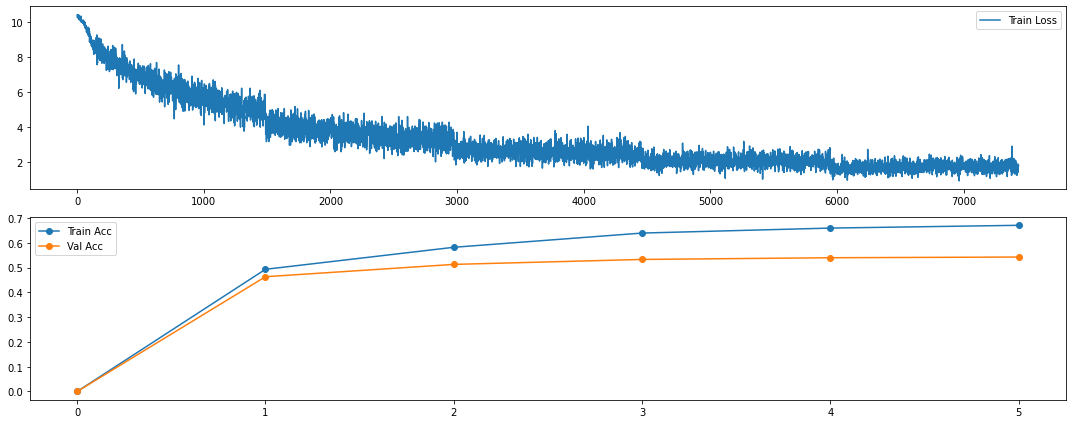

In [12]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

As we did previously, we will highlight some samples from the model and see the different weights applied to the context:

In [14]:
higlight_samples(m, sa_dev_dataset, sample_size=5, correct_only=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
1,1,5,made,make.v.01,make.v.01,1.965e-07,15.031237,Only,a,token,start,was,made,in,attacking,the,tax,reappraisal,question,and,its,companion,issue,of,attracting,industry,to,the,state,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,5,Bobby,person.n.01,person.n.01,1.257e-04,8.980794,She,was,going,to,tell,Bobby,Joe,about,how,mistaken,she,had,been,",",but,he,brought,one,of,the,cousins,home,for,supper,",",and,all,they,did,was,talk,about,antelope,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,8,5,large,large.a.01,large.a.01,6.496e-08,15.617559,What,is,noteworthy,about,this,large,group,of,teen-agers,is,that,",",although,their,attitudes,hardly,differentiate,them,from,their,gentile,counterparts,",",they,actually,lead,their,lives,in,a,vast,self,enclosed,Jewish,cosmos,with,relatively,little,contact,with,the,non,Jewish,world,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,11,5,inner,inner.s.01,inner.s.01,6.015e-07,14.170012,There,are,several,closely,related,inner,functions,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,13,5,very,very.r.01,very.r.01,3.204e-07,14.682156,<UNK>,",",however,",",are,very,rich,in,nutrients,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 4: Positional embeddings


After implementing relative embeddings in the model we can run the same test as before but this time with our new ability.

In [ ]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    use_relative_distance=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.570; epoch [4] loss: 1.601: 100%|██████████| 1487/1487 [02:38<00:00,  9.36it/s]


Plot the loss and training/validation accuracy.
Note that the accuracy has increased dramatically from the regular self-attention without positional encodings from `0.543` to `0.582`.

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")

Validation accuracy: 0.582, Training accuracy:0.708


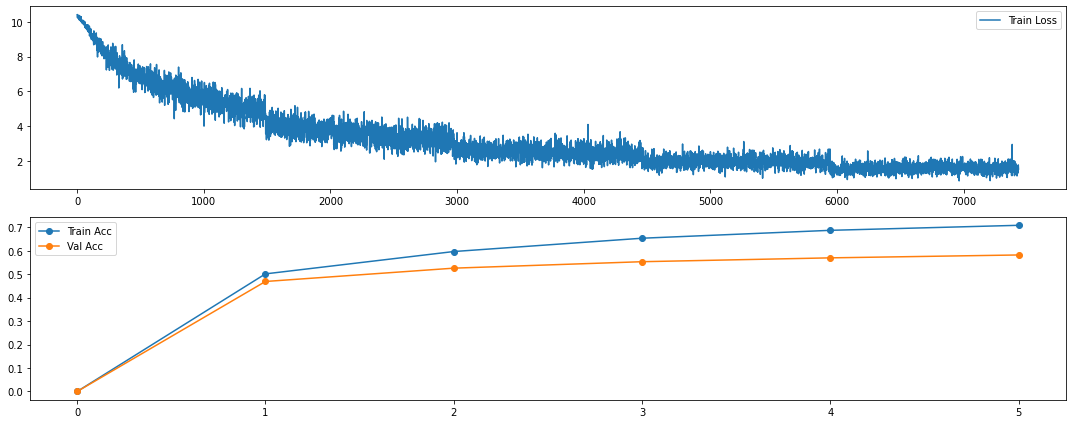

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

We can now visualize the weights of the model. Note that the weights are now significantly higher in the close vicinity of the queried word.
We prefer to look at only the correct words since this factors out unlabeled words (`no_sense`), since the visualisation just selects the sixth word of every sentence this is the best way of ignoring those results.

In [ ]:
higlight_samples(m, sa_dev_dataset, sample_size=5, correct_only=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
4,4,5,Eddie,person.n.01,person.n.01,9.949e-01,0.005076,The,Anniston,manager,looked,at,Eddie,Lee,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,6,5,were,be.v.01,be.v.01,4.760e-07,14.367133,You,also,",",when,you,were,dead,by,reason,of,your,offenses,and,sins,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,9,5,negative,negative.s.00,negative.s.00,1.981e-08,15.937392,Moreover,",",after,concentration,using,negative,pressure,dialysis,",",agglutinin,activity,could,sometimes,be,detected,in,the,region,designated,<UNK>,(,donors,P.,J.,",",D.,A.,",",and,J.,F.,",",Fig.,1,),.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,10,5,sentences,sentence.n.01,sentence.n.01,3.712e-08,15.802404,In,the,first,of,these,sentences,if,by,is,the,complement,of,come,and,Tuesday,is,an,adjunct,of,time,equivalent,to,on,Tuesday,",",there,will,be,strong,stress,on,by,in,the,spoken,language,;,but,if,a,complement,for,come,is,implied,and,by,Tuesday,is,a,prepositional,unit,used,as,an,adjunct,",",by,will,be,unstressed,or,lightly,stressed,at,most,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14,14,5,be,be.v.01,be.v.01,4.760e-07,14.367133,Its,terms,will,tend,to,be,<UNK>,or,vague,",",and,they,will,fit,actual,languages,more,and,more,badly,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 5: Causal Attention

After implementing Causal attention, all we need to do is run the model with the parameter `use_causal_attention=True`.
We will then check the visualisation to verify that queries do not attend on contexts that appear later in the sequence.

In [ ]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    use_relative_distance=True,
    use_causal_attention=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.558; epoch [4] loss: 1.693: 100%|██████████| 1487/1487 [02:38<00:00,  9.40it/s]


By plotting the loss and training/validation accuracy, we can see that the accuraccy has dropped since we added another constraint to the model.

In [ ]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")

Validation accuracy: 0.563, Training accuracy:0.683


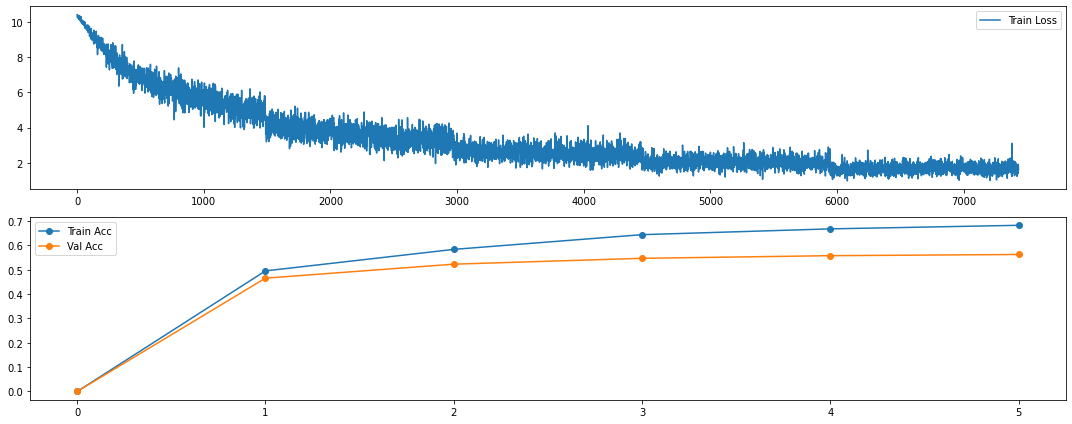

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

Visualising the attention we can see that it is indeed causal and that the model doesn't attend on future contexts!

In [ ]:
higlight_samples(m, sa_dev_dataset, sample_size=5, correct_only=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
1,1,5,made,make.v.01,make.v.01,1.233e-08,16.001804,Only,a,token,start,was,made,in,attacking,the,tax,reappraisal,question,and,its,companion,issue,of,attracting,industry,to,the,state,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,5,Bobby,person.n.01,person.n.01,1.776e-04,8.635534,She,was,going,to,tell,Bobby,Joe,about,how,mistaken,she,had,been,",",but,he,brought,one,of,the,cousins,home,for,supper,",",and,all,they,did,was,talk,about,antelope,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,8,5,large,large.a.01,large.a.01,5.472e-08,15.681643,What,is,noteworthy,about,this,large,group,of,teen-agers,is,that,",",although,their,attitudes,hardly,differentiate,them,from,their,gentile,counterparts,",",they,actually,lead,their,lives,in,a,vast,self,enclosed,Jewish,cosmos,with,relatively,little,contact,with,the,non,Jewish,world,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,11,5,inner,inner.s.01,inner.s.01,3.376e-08,15.827196,There,are,several,closely,related,inner,functions,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,13,5,very,very.r.01,very.r.01,5.281e-09,16.066633,<UNK>,",",however,",",are,very,rich,in,nutrients,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
